In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c693df92567481f972f60678419121425a041f0064e7b99c5e808c107c7c782d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
from pyspark.sql.functions import*
from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()
import matplotlib.pyplot as plt

**READ DATA**

In [6]:
DataRamen = spark.read.option("inferSchema", "true").csv("MsRamen.csv", header = True)
DataCustomer = spark.read.option("inferSchema", "true").csv("MsCustomer.csv", header = True)
DataCountry = spark.read.option("inferSchema", "true").csv("MsCountry.csv", header = True)
DataBrand = spark.read.option("inferSchema", "true").csv("MsBrand.csv", header = True)
DataRamenstyle = spark.read.option("inferSchema", "true").csv("MsRamenStyle.csv", header = True)
DataTransactionheader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header = True)
DataTransactiondetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header = True)

In [7]:
#Ubah tabel menjadi tabel yang dapat dibaca oleh Spark
DataRamen.registerTempTable("MsRamen")
DataCustomer .registerTempTable("MsCustomer")
DataCountry.registerTempTable("MsCountry")
DataBrand.registerTempTable("MsRamenStyle")
DataRamenstyle.registerTempTable("MsBrand")
DataTransactionheader.registerTempTable("TransactionHeader")
DataTransactiondetail.registerTempTable("TransactionDetail")

**1.Show The Year monthly of RamenShop data that above average of all monthly income using line chart.**


In [42]:
monthlyIncome = spark.sql("""
    SELECT
        DATE_FORMAT (TransactionDate, "MMM") AS Month,
        SUM(Quantity * RamenPrice) AS Income
    FROM TransactionHeader th
    JOIN TransactionDetail td
    ON th.TransactionID = td.TransactionID
    JOIN MsRamen mr
    ON mr. RamenID = td. RamenID
    GROUP BY
      MONTH (TransactionDate),
      DATE_FORMAT (TransactionDate, "MMM")
      ORDER BY MONTH(TransactionDate)
""")
monthlyIncome.show()

+-----+---------+
|Month|   Income|
+-----+---------+
|  Jan|316534000|
|  Feb|292087000|
|  Mar|328064000|
|  Apr|302013000|
|  May|305102000|
|  Jun|310177000|
|  Jul|312101000|
|  Aug|328337000|
|  Sep|307199000|
|  Oct|317046000|
|  Nov|317946000|
|  Dec|295857000|
+-----+---------+



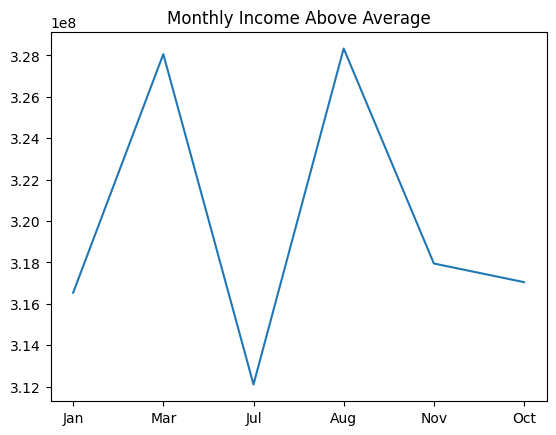

In [43]:
averageIncome = monthlyIncome.agg (avg ("Income").alias("avgIncome" ))

result = monthlyIncome.crossJoin (averageIncome).filter (col ("Income") > col("avgIncome" ) )
result = result. toPandas ()
plt.plot(result ["Month"], result ["Income"])
plt.title("Monthly Income Above Average")
plt.show()

 2.Show The frequency of customer Spending category in RamenShop. Each customer Spending Category is determined by below condition:
 ```
    Total Spend            MemberShip
      <100K                   Low
     100-1M                   Mid
       1M                     Mega
```


In [40]:
customerSpend = spark.sql("""
    SELECT
      mc. CustomerID,
      SUM(Quantity * RamenPrice) AS TotalSpend,
      CASE
          WHEN SUM(Quantity * RamenPrice) < 100000
          THEN 'Low'
          WHEN SUM(Quantity * RamenPrice)
            BETWEEN 100000 AND 1000000
          THEN 'Mid'
          WHEN SUM(Quantity * RamenPrice) > 1000000
          THEN 'Mega'
        END AS Category
    FROM MsCustomer mc
    JOIN TransactionHeader th
    ON mc. CustomerID = th. CustomerID
    JOIN TransactionDetail td
    ON td.TransactionID = th.TransactionID
    JOIN MsRamen mr
    ON td.RamenID = mr. RamenID
    GROUP BY mc.CustomerID
""")
customerSpend.show()

+----------+----------+--------+
|CustomerID|TotalSpend|Category|
+----------+----------+--------+
|      1959|   1398000|    Mega|
|      1591|    266000|     Mid|
|      1645|    816000|     Mid|
|      2866|    796000|     Mid|
|      1238|   1154000|    Mega|
|      1088|   3303000|    Mega|
|       463|   1819000|    Mega|
|      2366|    520000|     Mid|
|      1829|    256000|     Mid|
|      2659|   1345000|    Mega|
|      1342|    568000|     Mid|
|       471|    587000|     Mid|
|       496|    832000|     Mid|
|      2142|    709000|     Mid|
|       833|   1366000|    Mega|
|       148|    727000|     Mid|
|      1580|    503000|     Mid|
|      2387|    845000|     Mid|
|       540|   1192000|    Mega|
|      2235|   2679000|    Mega|
+----------+----------+--------+
only showing top 20 rows



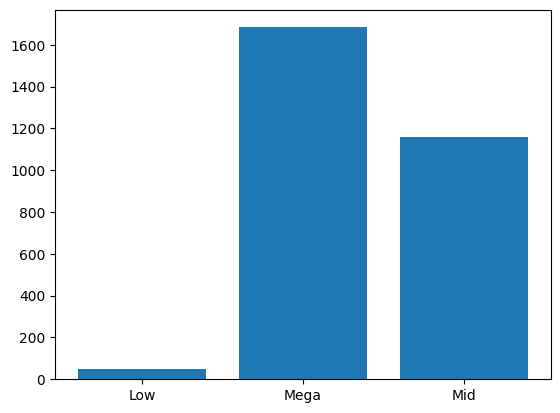

In [41]:
result = customerSpend.groupBy ("Category").agg (count ("CustomerID") .alias ("Frequency"))
result = result. toPandas ()
plt.bar(result["Category"], result["Frequency"])
plt.show()

**3. Show Top 5 Customer with the most transaction for customer with indonesian phone Number using pie chart.**

In [37]:
TransactionCustomer = spark.sql("""
  SELECT CustomerName,
    COUNT(TransactionID) AS TotalTransaction
  FROM MsCustomer c
  JOIN TransactionHeader th
  ON c.CustomerID = th.CustomerID
  WHERE CustomerPhone LIKE "+62%"
  GROUP BY CustomerName
  ORDER BY TotalTransaction DESC
  LIMIT 5
""")
TransactionCustomer.show()


+-----------------+----------------+
|     CustomerName|TotalTransaction|
+-----------------+----------------+
|      Matt Towhey|               9|
|Roderigo Sjostrom|               9|
|  Nananne Celloni|               9|
|          Lon Rex|               9|
|   Darb Ivanyutin|               8|
+-----------------+----------------+



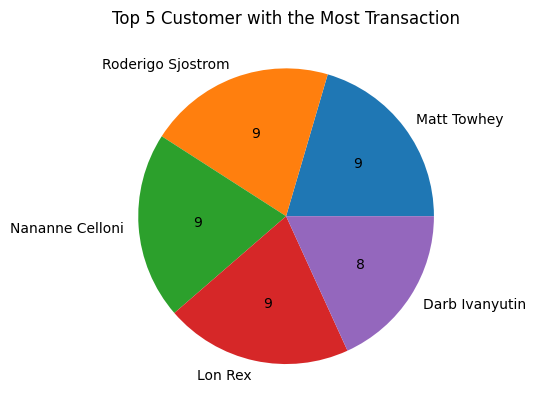

In [39]:
TotalTransaction = TransactionCustomer.toPandas()

#Make Pie Chart
plt.pie (TotalTransaction["TotalTransaction"], labels= TotalTransaction["CustomerName"],autopct=lambda p: '{:.0f}'.format(p *TotalTransaction["TotalTransaction"].sum() / 100))
plt.title('Top 5 Customer with the Most Transaction')
plt.show()